In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import io
import joblib
import zlib
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import os
import random
from joblib import dump, load
import gzip
import msgpack
import sys
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC  # Import SVM
from sklearn.model_selection import train_test_split
from sklearn.utils import resample


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.DataFrame()
for i in range(1, 11):
    df1 = pd.DataFrame()
    df1 = pd.read_csv(f'/content/drive/MyDrive/BTP-DataSets/MHEALTHDATASET/mHealth_subject{i}.log', header=None, sep='\t')
    df1 = df1.rename(columns={0: "acx", 1: "acy", 2: "acz", 3: "es1", 4: "es2",
                              5: "alx", 6: "aly", 7: "alz", 8: "glx", 9: "gly", 10: "glz", 11: "mlx", 12: "mly",
                              13: "mlz", 14: "arx", 15: "ary", 16: "arz", 17: "grx", 18: "gry", 19: "grz", 20: "mrx",
                              21: "mry", 22: "mrz", 23: "Activity"})
    df = pd.concat([df, df1])

<Axes: >

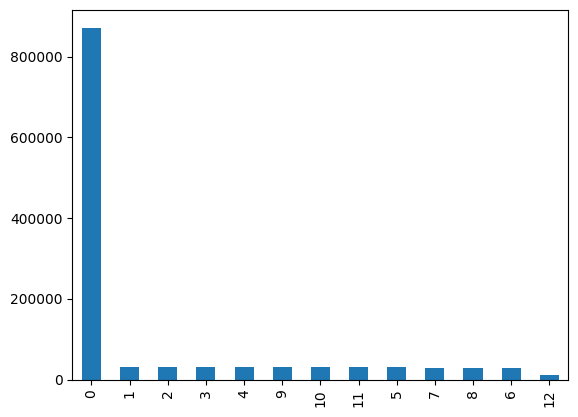

In [4]:
pd.value_counts(df['Activity']).plot.bar()

In [5]:
from sklearn.utils import resample

df_majority = df[df.Activity==0]
df_minorities = df[df.Activity!=0]

df_majority_downsampled = resample(df_majority,n_samples=30000, random_state=50)
df = pd.concat([df_majority_downsampled, df_minorities])
df.Activity.value_counts()

1     30720
2     30720
3     30720
4     30720
9     30720
10    30720
11    30720
5     30720
0     30000
7     29441
8     29337
6     28315
12    10342
Name: Activity, dtype: int64

In [6]:
num_of_clusters = 5
clusters_df=[]
for _ in range(num_of_clusters):
    clusters_df.append(df.sample(100000, replace=False))
cluster_heads=np.array([-1,-1,-1,-1,-1])

In [7]:
workers_info = []
energy_for_edge_at_start = 100000

# data, cluster no, edge score, model - coeff, model - intercept, energy consumed, acc
for i in range(5):
    for j in range(5):
        worker_data = pd.DataFrame(clusters_df[i].sample(30000, replace=False))
        worker_id = i
        worker_score = 0
        worker_coef = 0
        worker_intercept = 0
        worker_energy = []
        energy_acc = []
        energy = energy_for_edge_at_start
        workers_info.append([worker_data, worker_id, worker_coef, worker_score,
                             worker_intercept, worker_energy, energy_acc, energy])

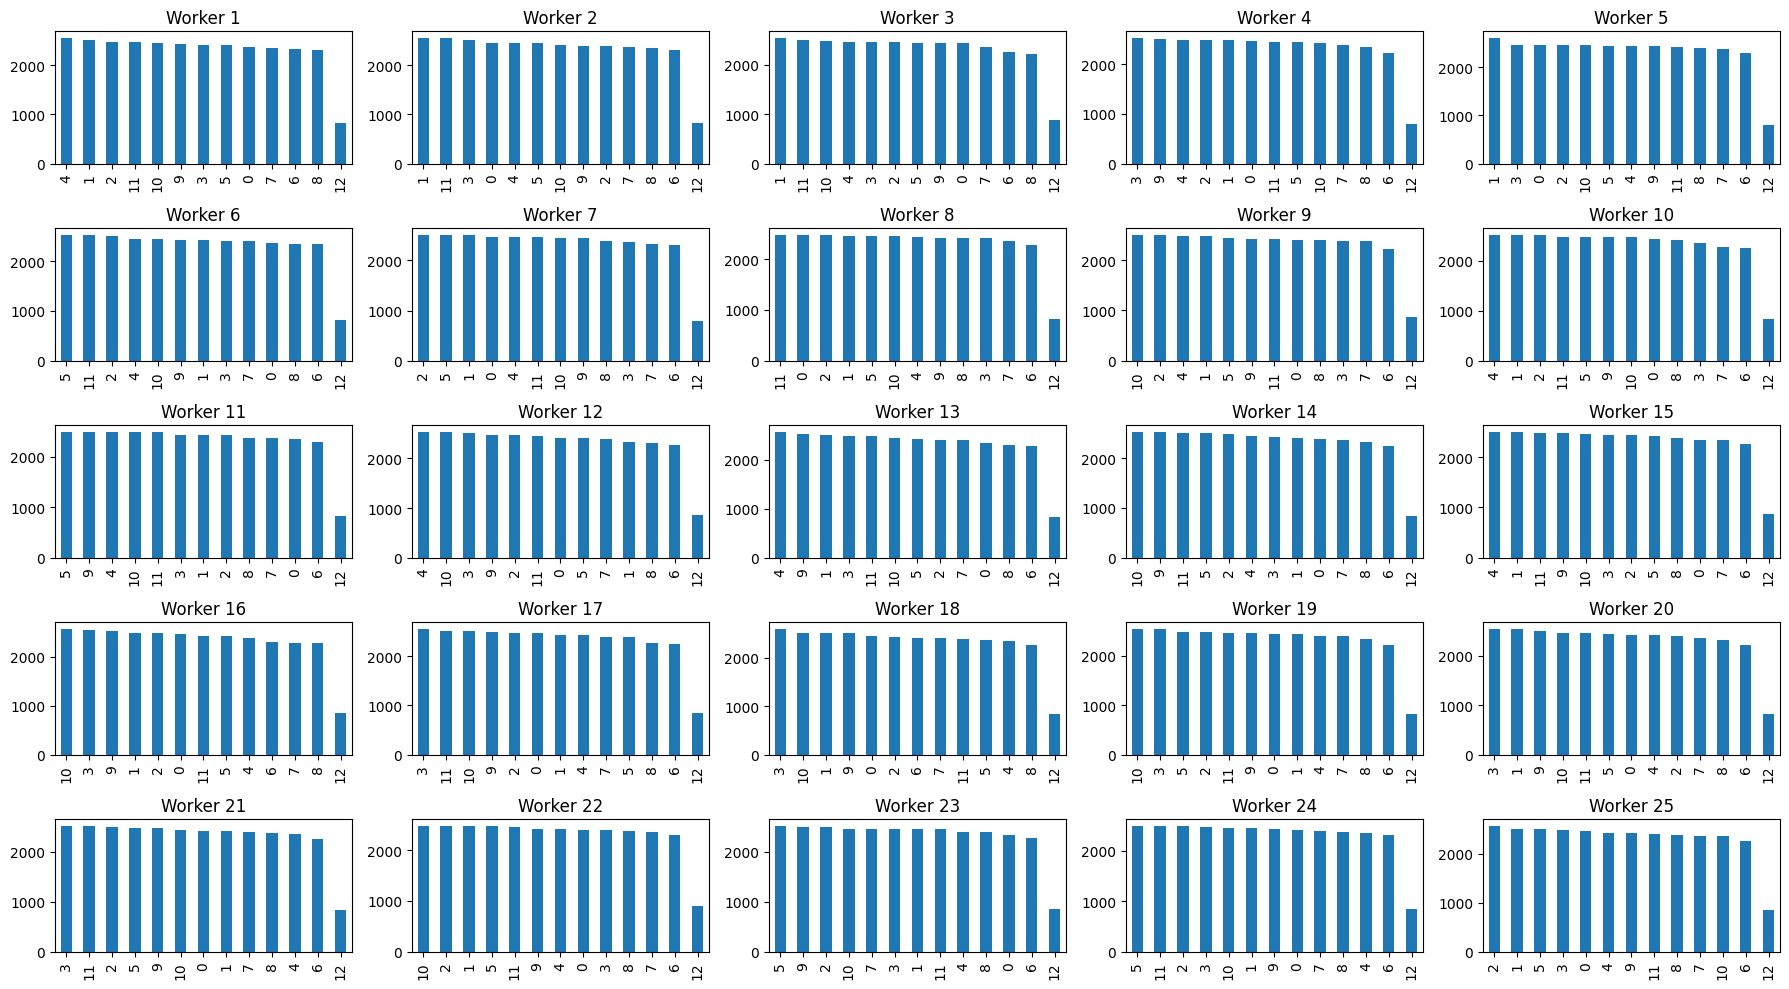

In [8]:
fig = plt.figure(figsize=(18, 10))
for i, worker in enumerate(workers_info):
    ax = fig.add_subplot(5, 5, i + 1)
    pd.value_counts(worker[0]['Activity']).plot.bar(ax=ax)
    ax.set_title(f'Worker {i + 1}')
fig.tight_layout()
plt.show()

In [9]:
import gzip
import io
import joblib
import msgpack
import zlib

def extract(message):
    if message is None:
        return None, None

    try:
        # Use joblib.load to handle non-compressed models
        model = joblib.load(io.BytesIO(message))
        return model, None
    except Exception:
        pass

    try:
        # Handle gzipped models
        decompressed_byte_array = zlib.decompress(message)
        model = joblib.load(io.BytesIO(decompressed_byte_array))
        return model, None
    except Exception:
        pass

    # Return default values if extraction fails
    return None, None

def compress(model):
    try:
        # Save the model to a BytesIO object using joblib.dump
        model_bytesio = io.BytesIO()
        joblib.dump(model, model_bytesio)

        # Get the serialized model bytes
        model_bytes = model_bytesio.getvalue()

        # Compress the serialized model using gzip
        compressed_model = gzip.compress(model_bytes)

        # Store the compressed model in a MessagePack container
        message_pack_container = msgpack.packb([compressed_model])
        return message_pack_container
    except Exception:
        return None


In [10]:
max_rounds = 100  # Maximum number of training rounds
req_accuracy = 0.80  # Minimum accuracy threshold
negligible_change = 0.0001  # Change in accuracy to be considered negligible
energy_for_each_iteration=0.01
num_of_workers=25
def energy_for_transmit(data):
    power = 1
    # energy = power * time = time = data / power = data
    return data

def terminate(accuracy, best_accuracy):
    if accuracy >= req_accuracy or abs(accuracy - best_accuracy) < negligible_change:
        return True
    return False

# Import SVM Classifier
from sklearn.svm import SVC

# Modify local_worker_training function to use SVM instead of RF
def local_worker_training(worker_num, global_model):
    # Shuffle the data before splitting
    workers_info[worker_num][0] = workers_info[worker_num][0].sample(frac=1, random_state=42)

    ltrain, ltest = train_test_split(workers_info[worker_num][0], test_size=0.2, random_state=42)
    lX_train = ltrain.drop('Activity', axis=1)
    ly_train = ltrain['Activity']
    lX_test = ltest.drop('Activity', axis=1)
    ly_test = ltest['Activity']

    model = SVC(kernel='rbf')  # Using non-linear kernel

    energy_consumption_in_local = 0

    if worker_num in cluster_heads and workers_info[worker_num][2] is not None:
        energy_consumption_in_local = energy_for_transmit(sys.getsizeof(workers_info[worker_num][5]) +
                                                          sys.getsizeof(workers_info[worker_num][6]))

        # If the global model coefficients are available, set them during training
        sample_weights, _ = extract(workers_info[worker_num][2])

        if sample_weights is not None:
            sample_weights = np.ones(len(lX_train)) if sample_weights.size != len(lX_train) else sample_weights
            model.fit(lX_train, ly_train, sample_weight=sample_weights)
        else:
            model.fit(lX_train, ly_train)

        if sample_weights is not None and sample_weights.size > 1 and sample_weights.shape[0] != len(lX_train):
            sample_weights = np.repeat(sample_weights, len(lX_train) // len(sample_weights) + 1)[:len(lX_train)]

    else:
        model.fit(lX_train, ly_train)

    accuracy = model.score(lX_test, ly_test)

    energy_consumption_in_local += max_rounds * energy_for_each_iteration
    workers_info[worker_num][5].append(energy_consumption_in_local)
    workers_info[worker_num][6].append(accuracy)
    workers_info[worker_num][7] -= energy_consumption_in_local

    print("local worker:", worker_num, "acc:", accuracy, "round no:", max_rounds,
          "energy remaining:", workers_info[worker_num][7])

In [11]:
def training_workers(global_model=None):
    for i in range(num_of_workers):
        local_worker_training(i, global_model)

In [12]:
def cal_batter_life(energy_rem):
    return (energy_rem / energy_for_edge_at_start) * 100


In [13]:
# Modify the cal_edge_score function
def cal_edge_score():
    w1=0.4
    w2=0.6
    for i in range(num_of_workers):
        workers_info[i][3]=w1*workers_info[i][6][-1]+w2*cal_batter_life(workers_info[i][7])


# Modify the cal_clusters_head function
def cal_clusters_head():
    for i in range(5):
        max_score_edge=i*5
        for j in range(1,5):
            if workers_info[i*5+j][3]>workers_info[max_score_edge][3]:
	            max_score_edge=i*5+j
        cluster_heads[i]=max_score_edge


In [14]:
def global_aggregation(global_model):
    training_workers(global_model)
    cal_edge_score()
    cal_clusters_head()

    new_global_model = SVC(kernel='rbf', random_state=42)

    num_contributing_workers = 0

    for i in range(num_of_clusters):
        worker_model, _ = extract(workers_info[i][2])

        if worker_model:
            if num_contributing_workers == 0:
                new_global_model = copy.deepcopy(worker_model)
            else:
                new_global_model.dual_coef_ += worker_model.dual_coef_
            num_contributing_workers += 1

    if num_contributing_workers > 0:
        new_global_model.dual_coef_ /= num_contributing_workers

    return new_global_model

In [18]:
max_global_rounds = 15
acc = []
global_model = None

# Global aggregation loop
for i in range(max_global_rounds):
    global_model = global_aggregation(global_model)
    compressed_model = compress(global_model)

    temp_max_acc = 0
    for j in range(num_of_workers):
        if len(workers_info[j][6]) > i and workers_info[j][6][i] is not None:
            workers_info[j][2] = compressed_model
            temp_max_acc = max(temp_max_acc, workers_info[j][6][i])

    acc.append(temp_max_acc)
    print("Round - Global", i, "Accuracy", temp_max_acc)

local worker: 0 acc: 0.7578333333333334 round no: 0 energy remaining: 100000.0
local worker: 1 acc: 0.7618333333333334 round no: 0 energy remaining: 100000.0
local worker: 2 acc: 0.7561666666666667 round no: 0 energy remaining: 100000.0
local worker: 3 acc: 0.762 round no: 0 energy remaining: 100000.0
local worker: 4 acc: 0.7613333333333333 round no: 0 energy remaining: 100000.0
local worker: 5 acc: 0.7526666666666667 round no: 0 energy remaining: 100000.0
local worker: 6 acc: 0.7558333333333334 round no: 0 energy remaining: 100000.0
local worker: 7 acc: 0.754 round no: 0 energy remaining: 100000.0
local worker: 8 acc: 0.749 round no: 0 energy remaining: 100000.0
local worker: 9 acc: 0.7638333333333334 round no: 0 energy remaining: 100000.0
local worker: 10 acc: 0.7611666666666667 round no: 0 energy remaining: 100000.0
local worker: 11 acc: 0.7565 round no: 0 energy remaining: 100000.0
local worker: 12 acc: 0.749 round no: 0 energy remaining: 100000.0
local worker: 13 acc: 0.7606666666

In [20]:
total_energy_per_round = []
energy_per_round = []
total_energy = 0

# Determine the maximum number of rounds based on the length of the energy consumption data for any worker
max_rounds = min(len(worker_info[5]) for worker_info in workers_info)

# Iterate over the rounds
for i in range(max_rounds):
    energy = 0
    for j in range(num_of_workers):
        # Check if the current round index i is within the range of energy consumption data for worker j
        if i < len(workers_info[j][5]):
            total_energy += workers_info[j][5][i]
            energy += workers_info[j][5][i]
    energy_per_round.append(energy)
    total_energy_per_round.append(total_energy)
    print(f"Round {i+1} energy: {energy}")




Round 1 energy: 0.0
Round 2 energy: 880.0
Round 3 energy: 880.0
Round 4 energy: 880.0
Round 5 energy: 880.0
Round 6 energy: 1200.0
Round 7 energy: 1200.0
Round 8 energy: 1200.0
Round 9 energy: 1200.0
Round 10 energy: 1840.0
Round 11 energy: 1840.0
Round 12 energy: 1840.0
Round 13 energy: 1840.0
Round 14 energy: 1840.0
Round 15 energy: 1840.0


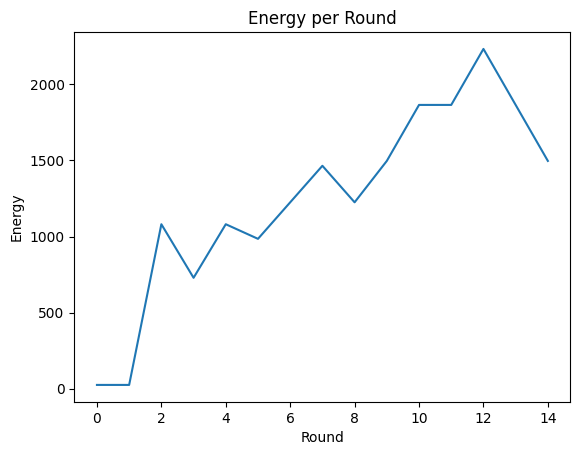

In [ ]:
plt.plot(energy_per_round)
plt.xlabel("Round")
plt.ylabel("Energy")
plt.title("Energy per Round")
plt.show()

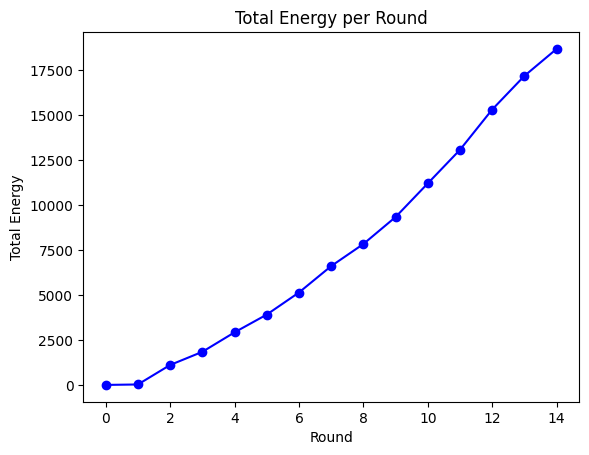

In [ ]:
plt.plot(total_energy_per_round, marker='o', linestyle='-', color='b')
plt.xlabel("Round")
plt.ylabel("Total Energy")
plt.title("Total Energy per Round")
plt.show()

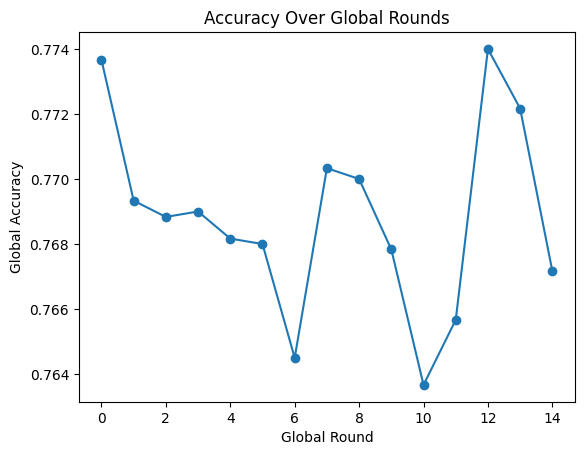

In [ ]:
plt.plot(range(max_global_rounds), acc, marker='o')
plt.xlabel("Global Round")
plt.ylabel("Global Accuracy")
plt.title("Accuracy Over Global Rounds")
plt.show()


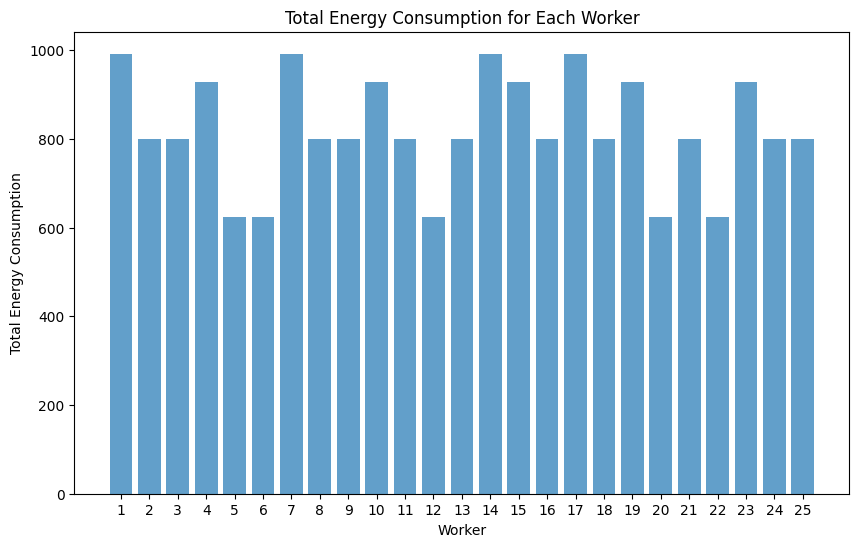

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

# Calculate the total energy consumption for each worker over local rounds
total_energy_per_worker = [sum(workers_info[i][5]) for i in range(num_of_workers)]

# Plotting a bar graph
ax.bar(range(1, num_of_workers + 1), total_energy_per_worker, align='center', alpha=0.7)
ax.set_xticks(range(1, num_of_workers + 1))
ax.set_xlabel('Worker')
ax.set_ylabel('Total Energy Consumption')
ax.set_title('Total Energy Consumption for Each Worker')

plt.show()

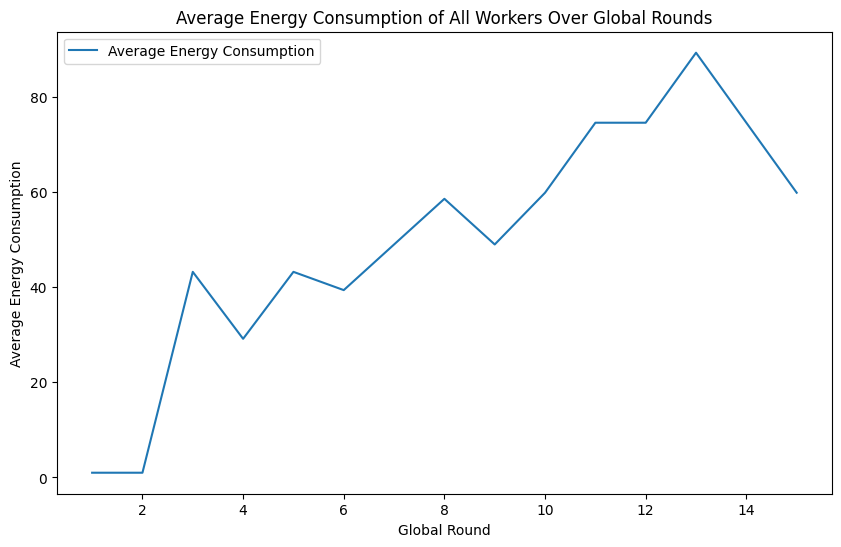

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a list `workers_info` that contains information about each worker's energy consumption

# Calculate the average energy consumption for each global round
average_energy_consumption_per_round = np.mean([worker_info[5][:max_global_rounds] for worker_info in workers_info], axis=0)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(range(1, max_global_rounds + 1), average_energy_consumption_per_round, label='Average Energy Consumption')
ax.set_xlabel('Global Round')
ax.set_ylabel('Average Energy Consumption')
ax.legend()
plt.title('Average Energy Consumption of All Workers Over Global Rounds')
plt.show()
